In [2]:
import blockulib
import blockulib.models as blom
import matplotlib.pyplot as plt
import torch
from abc import ABC, abstractmethod
from blockulib.utils import PositionList, ShallowList, DeepList
from blockulib.utils.tests import PositionListTests

In [8]:
tests = PositionListTests()
tests()

All tests passed


# New PlayingLoop structure
    work in progress - new Playing Loop structure will be more object oriented and hopefully faster thanks to PositionList

In [13]:
class PlayingLoop():
    
    def __init__(self,):
        self.generator = blockulib.BlockGenerator()
        self.pos_list_type = DeepList
    
    def __call__(self, num_games = 1, starting_positions = None):
        self.pos_list = self.pos_list_type(num_games, starting_positions)
        self.num_games = self.pos_list.num_games
        self.move = self.num_games
        
        while (self.pos_list.active_games > 0 and self.continue_condition()):
            self.move += 1
            boards = self.pos_list.active_boards()
            pos, ind = blockulib.possible_moves(boards, self.generator)
            chosen_moves = self.pick_moves(boards, pos, ind)
            self.pos_list.process_chosen_moves(chosen_moves)
                
        return self.pos_list()
    
    def continue_condition(self,):
        return True
    
    @abstractmethod
    def pick_moves(self, new_index, pos, ind):
        pass

In [15]:
class SimpleLoop(PlayingLoop):
    
    def pick_moves(self, new_index, pos, ind):
        chosen_moves = [None for i in range(len(new_index))]
        for i in range(ind.shape[0]):
            index = int(ind[i].item())
            if chosen_moves[index] is None:
                chosen_moves[index] = pos[i]
        return chosen_moves

In [17]:
class ModelBasedLoop(PlayingLoop):
    
    def __init__(self, model_path = "models/conv_model.pth", architecture = blom.ConvModel):
        super().__init__()
        self.model = architecture()
        state_dict = torch.load(model_path)
        self.model.load_state_dict(state_dict)
        self.model.eval()
        
    def pick_moves(self, new_index, pos, ind, pred_config = {}, rethink_config = {}, temperature = 1.0, top_k: int = 5):
        logits = self.get_model_pred(data = pos, **pred_config)
        pos, ind, logits = blockulib.cut_to_topk(pos, ind, logits, num_games = self.pos_list.active_games, top_k = top_k)
        logits = self.rethink_logits(pos, logits, **rethink_config)
        decisions = blockulib.logits_to_choices(logits, ind, self.pos_list.active_games, temperature = temperature, top_k = top_k)
        
        chosen_moves = [None for i in range(self.pos_list.active_games)]
        for i in range(self.pos_list.active_games):
            if decisions[i] is not None:
                chosen_moves[i] = pos[decisions[i]]
        return chosen_moves
                    
    def get_model_pred(self, data, batch_size = 2048, device = None):
        if (data.shape[0] == 0):
            return torch.tensor([])
        if device is None:
            device = ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        predictions = []
        
        with torch.no_grad():
            for i in range(0, data.shape[0], batch_size):
                batch = data[i:i+batch_size].to(device)
                batch = batch.unsqueeze(1)
                output = self.model(batch)
                predictions.append(output.cpu())
            
        return torch.cat(predictions).squeeze(1)
    
    def rethink_logits(self, pos, logits):
        return logits

In [19]:
loop = SimpleLoop()

In [21]:
pos = loop(num_games = 2)
print(len(pos[0]))

40


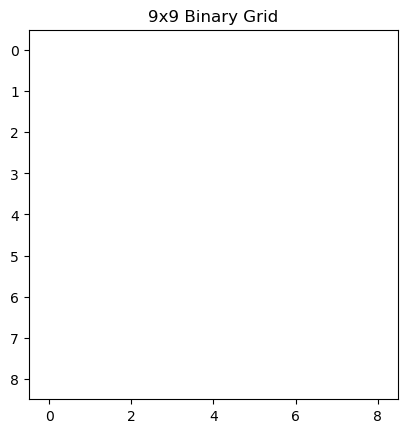

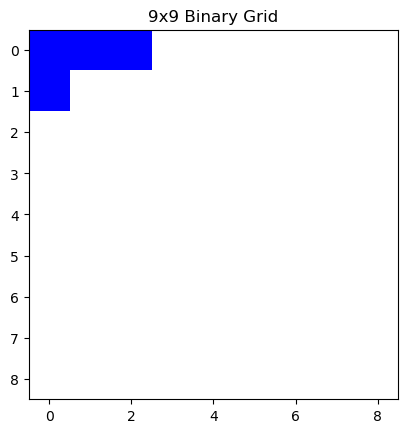

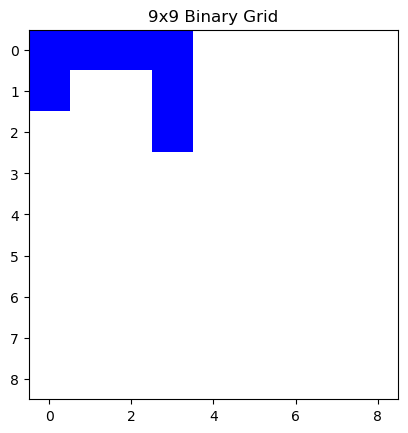

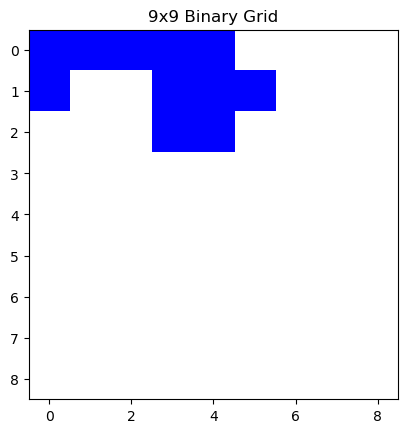

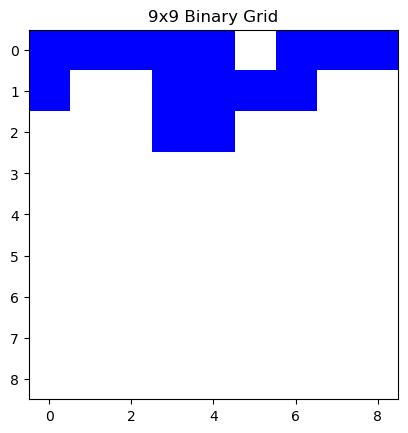

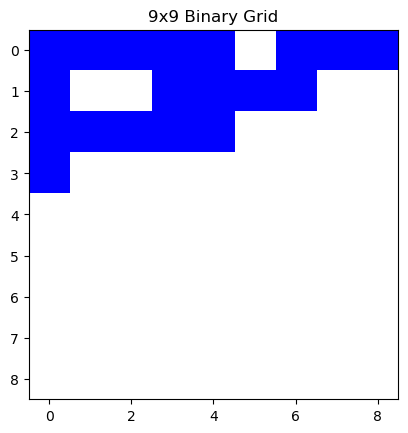

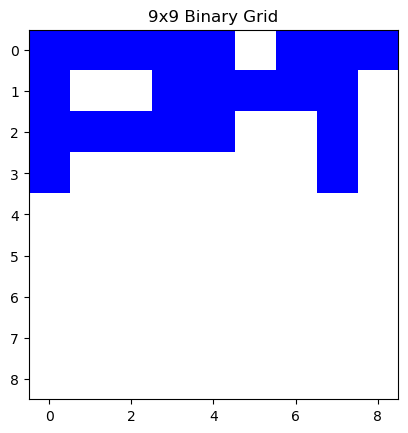

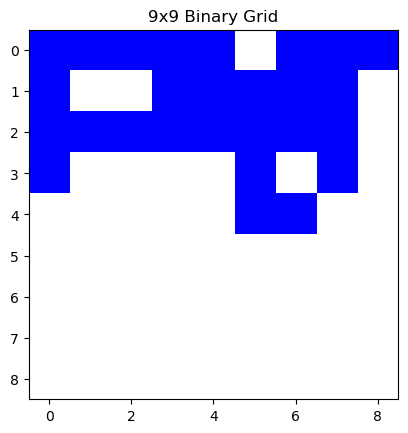

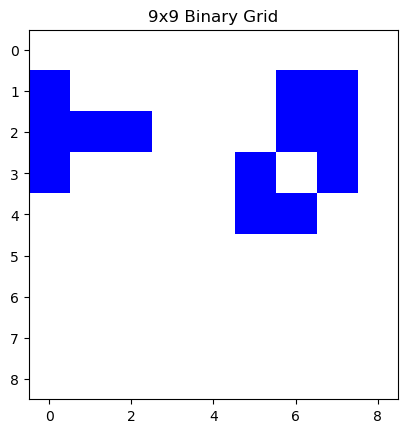

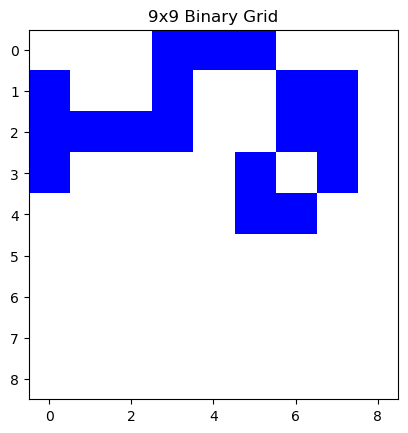

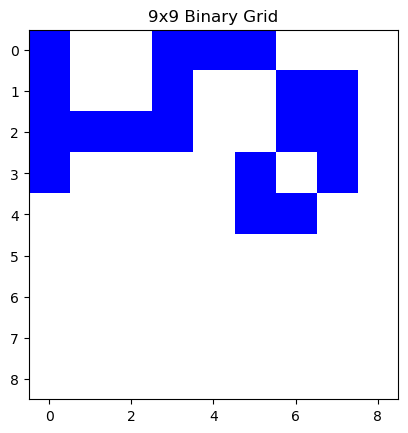

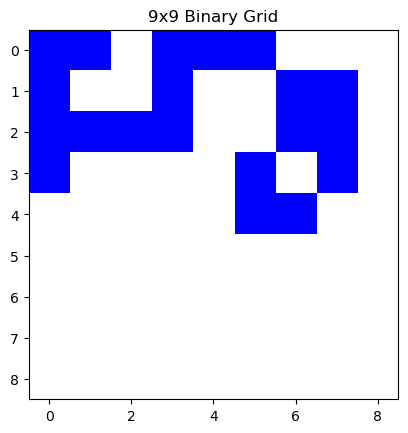

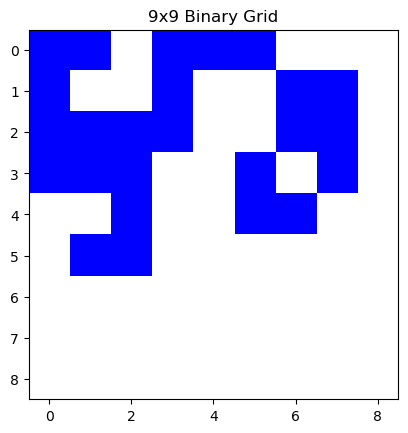

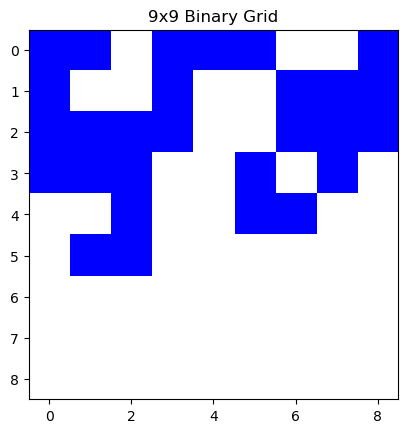

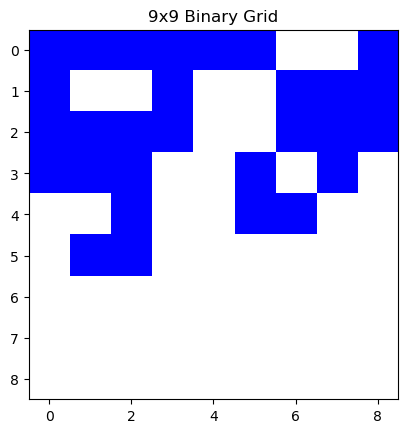

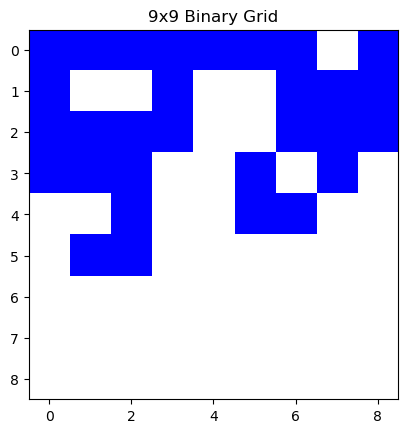

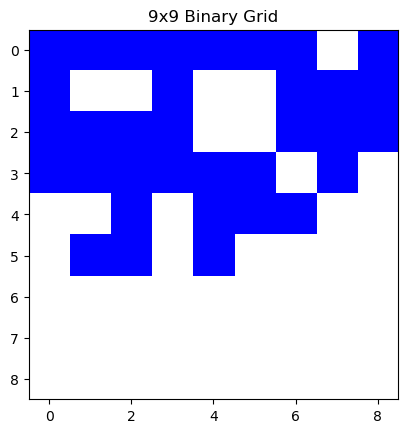

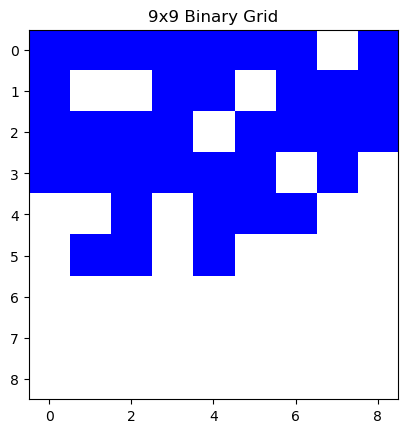

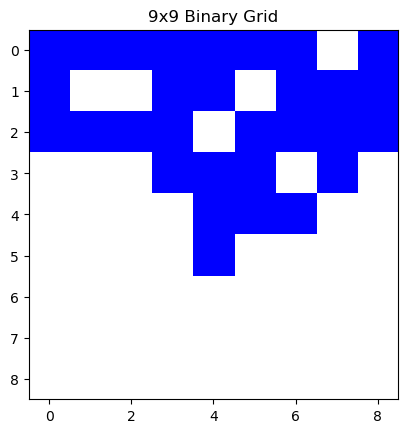

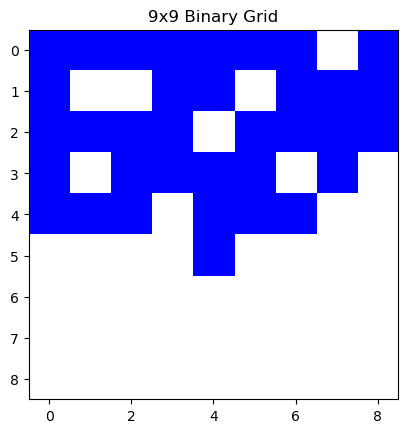

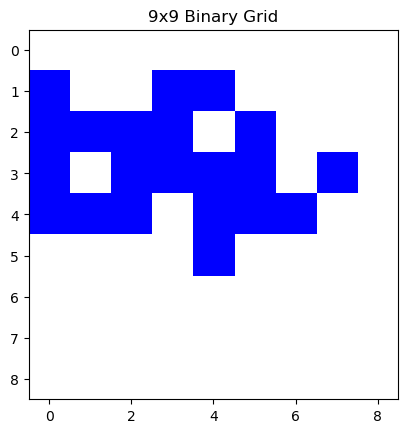

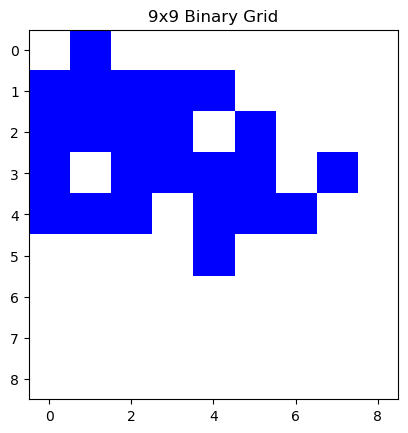

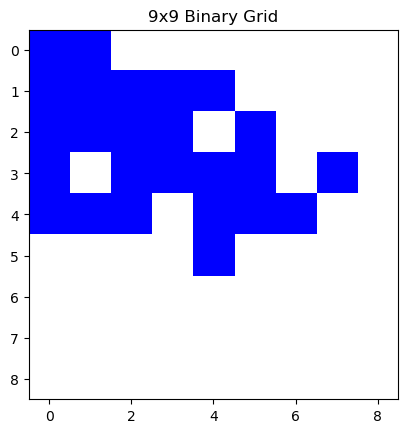

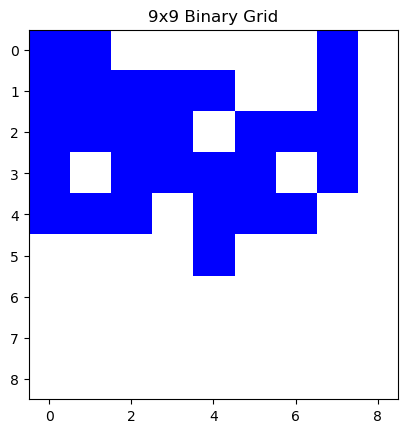

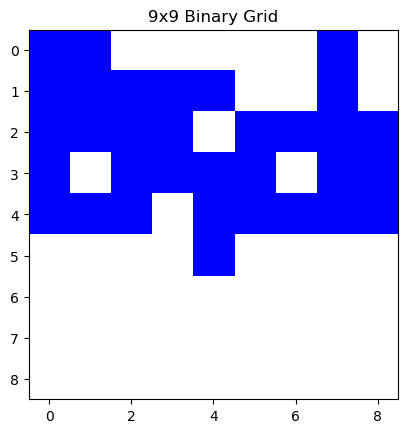

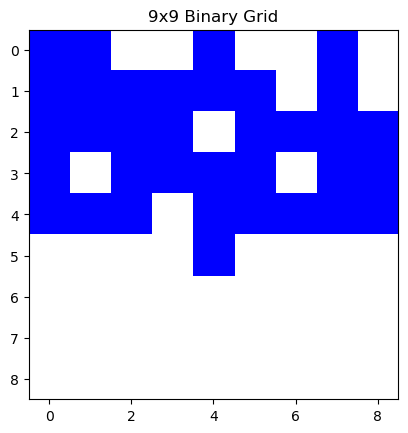

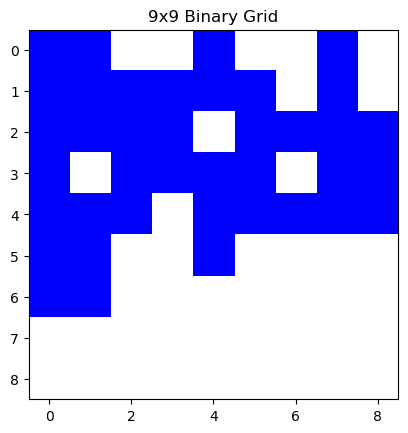

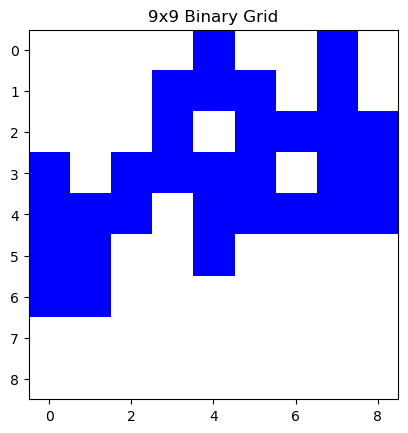

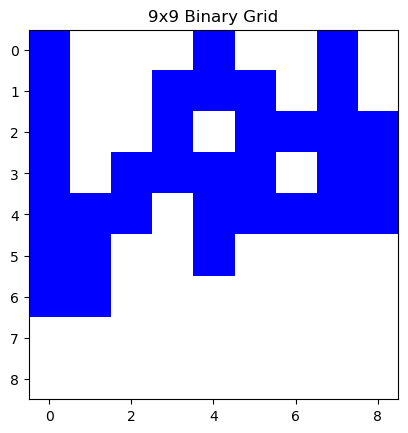

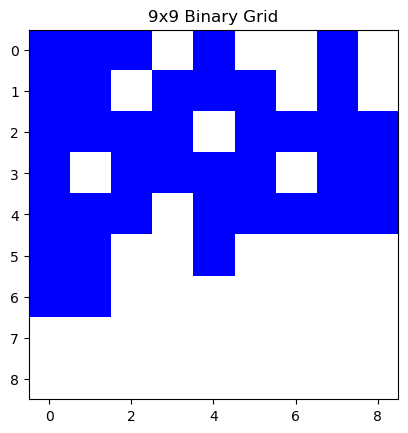

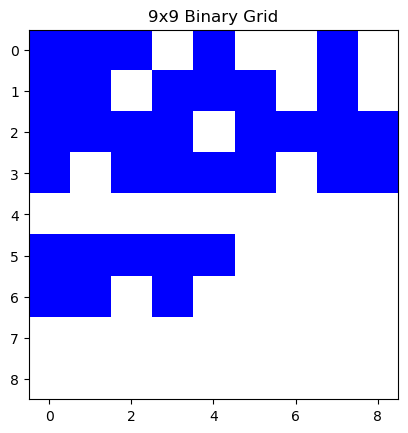

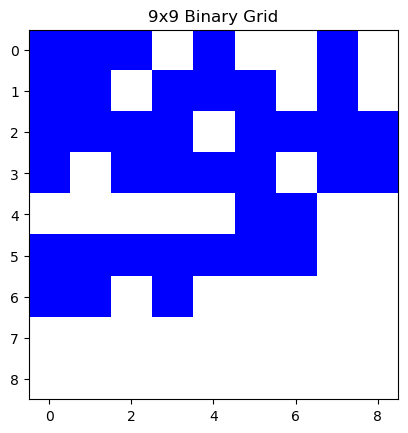

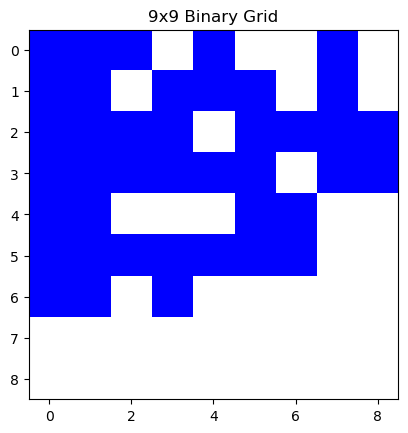

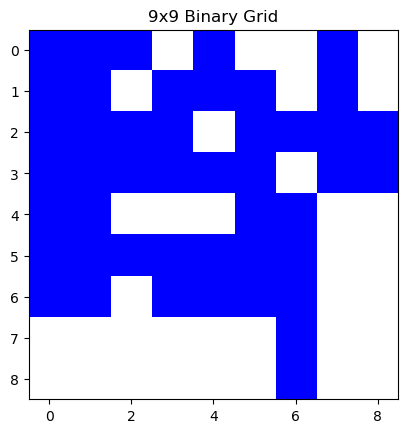

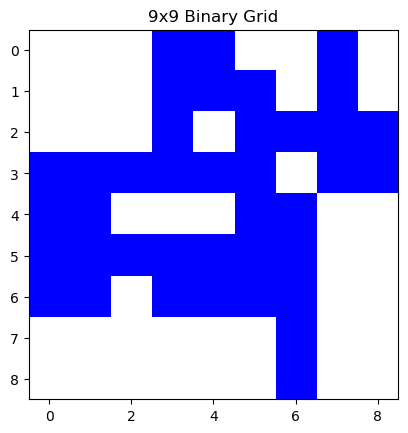

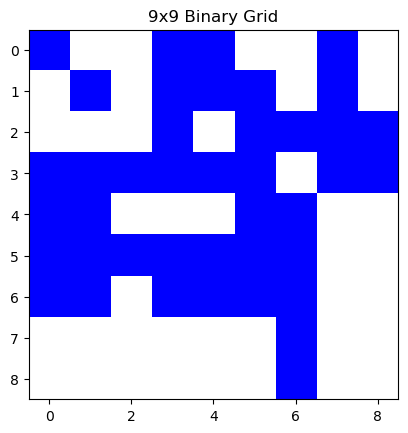

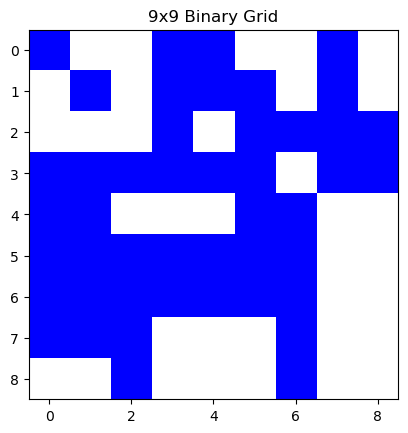

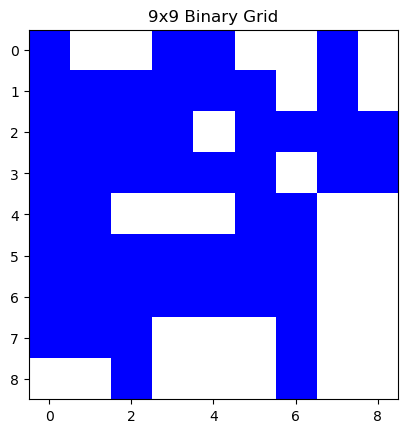

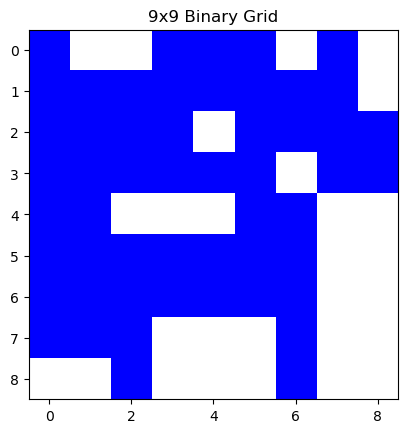

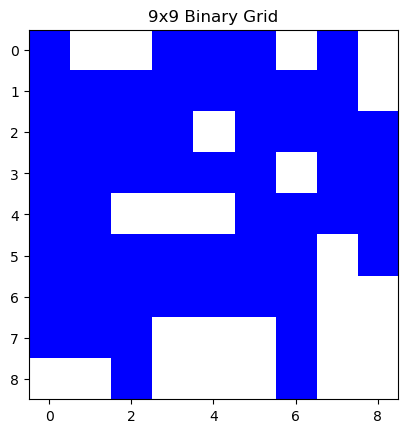

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def display_board(board):
    cmap = ListedColormap(["white", "blue"])

    plt.imshow(board, cmap=cmap, origin='upper', interpolation='nearest')
    plt.title("9x9 Binary Grid")
    plt.show()
    
for board in pos[0]:
   display_board(board) 

In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)